# Sec Recon Network

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

from itertools import combinations
from utils import get_gene_color, flatten_processes, adjust_color_alpha, categorize_location

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_csv("Input/masterTable.csv")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")
complexes = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="Complexes")

In [6]:
#Define sub-cellular localizations
secrecon

SYMBOL                                              ALIAS  \
0    A3GALT2                      A3GALT2P,IGB3S,IGBS3S,A3GALT2   
1     A4GALT        A14GALT,A4GALT1,Gb3S,P(k),P1,P1PK,PK,A4GALT   
2      A4GNT                                    alpha4GnT,A4GNT   
3       ABL1  ABL,BCR-ABL,CHDSKM,JTK7,bcr/abl,c-ABL,c-ABL1,p...   
4       ABL2                                      ABLL,ARG,ABL2   
..       ...                                                ...   
904   XXYLT1                                     C3orf21,XXYLT1   
905    XYLT1       DBQD2,PXYLT1,XT-I,XT1,XTI,XYLTI,xylT-I,XYLT1   
906    XYLT2                 PXYLT2,SOS,XT-II,XT2,xylT-II,XYLT2   
907     YKT6                                               YKT6   
908     YOD1                           DUBA8,OTUD2,PRO0907,YOD1   

                             ENSEMBL  ENTREZID  \
0                    ENSG00000184389    127550   
1                    ENSG00000128274     53947   
2                    ENSG00000118017     51146   
3                    ENSG00000097007        25   
4                    ENSG00000143322        27   
..                               ...       ...   
904                  ENSG00000173950    152002   
905  ENSG00000103489,ENSG00000285395     64131   
906                  ENSG00000015532     64132   
907                  ENSG00000106636     10652   
908                  ENSG00000180667     55432   

                                              GENENAME  \
0                    alpha 1,3-galactosyltransferase 2   
1      alpha 1,4-galactosyltransferase (P blood group)   
2            alpha-1,4-N-acetylglucosaminyltransferase   
3    ABL proto-oncogene 1, non-receptor tyrosine ki...   
4    ABL proto-oncogene 2, non-receptor tyrosine ki...   
..                                                 ...   
904                      xyloside xylosyltransferase 1   
905                               xylosyltransferase 1   
906                               xylosyltransferase 2   
907                               YKT6 v-SNARE homolog   
908                                YOD1 deubiquitinase   

                                                  PMID  \
0                  18630988,21873635,23378701,31762063   
1    10591208,10747952,10748143,10854428,10993874,1...   
2    8125298,10430883,11304796,12477932,12594234,15...   
3    1281542,1379745,1383690,1505033,1538749,157153...   
4    1383690,2198571,3787260,8125298,8194526,870054...   
..                                                 ...   
904  8982869,12477932,14702039,15489334,16303743,16...   
905  10383739,11087729,11099377,11814476,12477932,1...   
906  8889548,9588955,10383739,11087729,11099377,118...   
907  8125298,9211930,11474112,11884350,11927603,123...   
908  7644498,12477932,14702039,16710414,19322201,19...   

                                                REFSEQ  \
0                            NM_001080438,NP_001073907   
1    NM_001318038,NM_017436,NP_001304967,NP_059132,...   
2    NM_016161,NP_057245,XM_017006543,XM_017006544,...   
3              NM_005157,NM_007313,NP_005148,NP_009297   
4    NM_001136000,NM_001136001,NM_001168236,NM_0011...   
..                                                 ...   
904  NM_001308069,NM_152531,NP_001294998,NP_689744,...   
905  NM_022166,NP_071449,XM_017023539,XM_017023540,...   
906  NM_022167,NP_071450,NR_110010,XM_005257572,XP_...   
907  NM_001363678,NM_006555,NP_001350607,NP_006546,...   
908      NM_001276320,NM_018566,NP_001263249,NP_061036   

                      UNIPROT  \
0                      U3KPV4   
1           A0A0S2Z5J1,Q9NPC4   
2                      Q9UNA3   
3    A0A024R8E2,P00519,Q59FK4   
4                      P42684   
..                        ...   
904         A0A140T9D0,Q8NBI6   
905                    Q86Y38   
906             B4DT06,Q9H1B5   
907             A4D2J0,O15498   
908                    Q5VVQ6   

                                    Tissue specificity  \
0    Expressed in thymus and monocyte derived dendr...

In [12]:
secrecon['Subcellular location [CC]'] = secrecon['Subcellular location [CC]'].apply(categorize_location)
secrecon['Subcellular location [CC]']

0                                 [Golgi]
1                                 [Golgi]
2                                 [Golgi]
3      [Nucleus, Cytoplasm, Mitochondria]
4                             [Cytoplasm]
                      ...                
904               [Endoplasmic Reticulum]
905                               [Golgi]
906                               [Golgi]
907                           [Cytoplasm]
908                 [Cytoplasm, Lysosome]
Name: Subcellular location [CC], Length: 909, dtype: object

In [20]:
#Generate dictionaries

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['SYMBOL']
    # Grab the processes and filter out any NaN values
    # Add the subcellular localizations
    processes = row[['Process.1', 'Process.2', 'Process.3', 'Process.4', 'Process.5',
                     'Process.6', 'Process.7', 'Process.8', 'Process.9', 'Process.10']].dropna().tolist()
    localization = row['Subcellular location [CC]']
    gene_dict[gene] = {'processes': processes, 'subcellular_localization': localization}
    
# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})
    
#Complexes dict
complexes_dict = complexes.groupby('Gene')['Complex'].apply(list).to_dict()

In [21]:
# Add the complexes to the gene_dict. If a gene is not part of any complex, we will put 'Not part of any complex'
for gene in gene_dict:
    gene_dict[gene]['complex'] = complexes_dict.get(gene, 'Not part of any complex')

In [22]:
gene_dict

{'A3GALT2': {'processes': ['Isoglobo series'],
  'subcellular_localization': ['Golgi'],
  'complex': 'Not part of any complex'},
 'A4GALT': {'processes': ['Globo series'],
  'subcellular_localization': ['Golgi'],
  'complex': 'Not part of any complex'},
 'A4GNT': {'processes': ['O-glycan mucin'],
  'subcellular_localization': ['Golgi'],
  'complex': 'Not part of any complex'},
 'ABL1': {'processes': ['Kinase',
   'Cytoskeletal remodeling',
   'Endocytosis',
   'Apoptosis',
   'ER stress response/UPR'],
  'subcellular_localization': ['Nucleus', 'Cytoplasm', 'Mitochondria'],
  'complex': 'Not part of any complex'},
 'ABL2': {'processes': ['Kinase', 'Cytoskeletal remodeling', 'Endocytosis'],
  'subcellular_localization': ['Cytoplasm'],
  'complex': 'Not part of any complex'},
 'ABO': {'processes': ['Glycosylation'],
  'subcellular_localization': ['Golgi'],
  'complex': 'Not part of any complex'},
 'ACAP1': {'processes': ['Endocytic recycling', 'Clathrin'],
  'subcellular_localization': ['

## 2.Plots

### 2.1 Group by the processes and color by the parent process

In [10]:
# Colouring the nodes according the systems
category_colors = {
    'Translocation': 'blue',
    'Protein conformation': 'red',
    'Post-translational modifications': 'green',
    'Proteostasis': 'purple',
    'Vesicle trafficking': 'yellow'
}

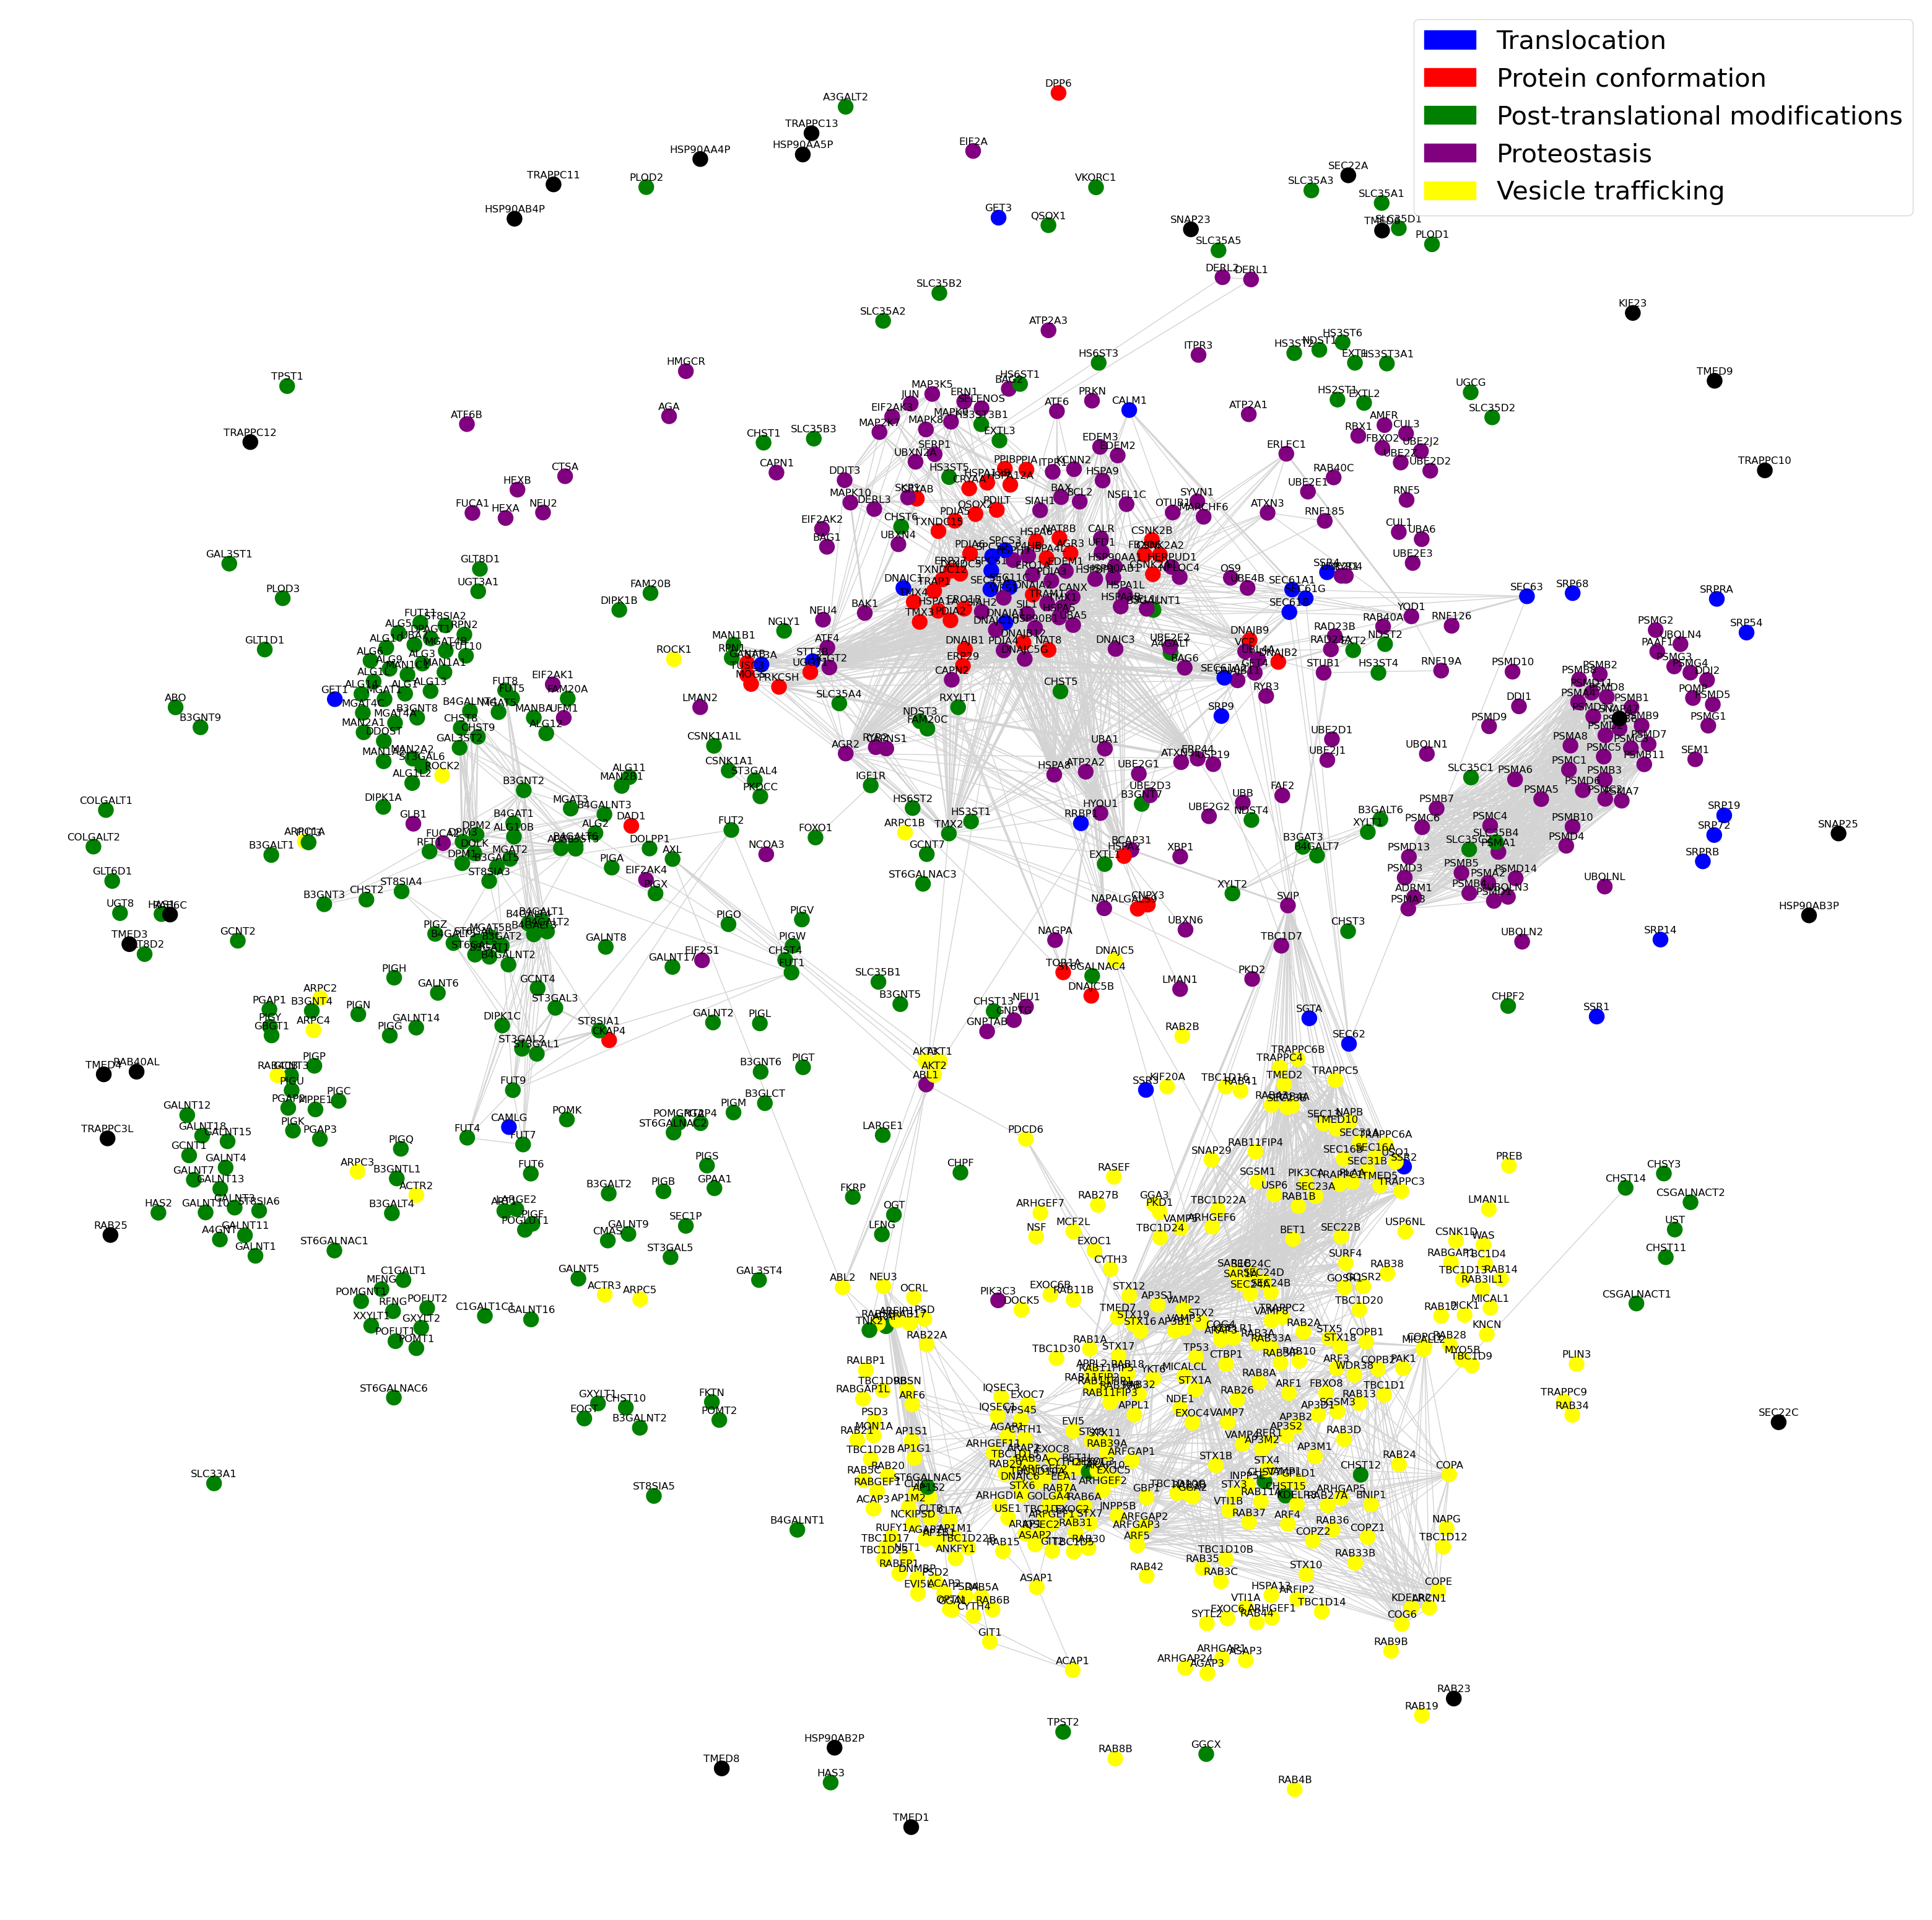

In [ ]:
####--- Plot the genes grouped by processes and color coded by the parent term ---####

# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.5)   # Set fixed position for nodes
# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]

nx.draw(G, pos, node_color=node_colors, edgelist=edgelist, node_size=300, edge_color='lightgrey', 
        width=[G[u][v]['weight'] for u, v in G.edges()], ax=ax)  # Set edge width to be proportional to the shared processes

# labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12) 

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 30}) 

plt.savefig('gene_network.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Group by the porcesses and color by the subcellular localization

In [52]:
localization_colors = {
    'Endosome': (0.8, 0.2, 0.2, 1.0), 
    'Recycling Endosome': (0.9, 0.3, 0.3, 1.0), 
    'Early Endosome': (0.85, 0.25, 0.25, 1.0), 
    'Late Endosome': (0.75, 0.15, 0.15, 1.0), 
    'Plasma Membrane': (0.2, 0.2, 0.8, 1.0), 
    'Golgi': (0.2, 0.8, 0.2, 1.0), 
    'cis-Golgi': (0.25, 0.85, 0.25, 1.0),
    'trans-Golgi': (0.15, 0.75, 0.15, 1.0), 
    'Nucleus': (0.9, 0.9, 0.1, 1.0),
    'Phagosome': (0.8, 0.2, 0.8, 1.0), 
    'Mitochondria': (0.1, 0.9, 0.9, 1.0),
    'Lysosome': (0.5, 0.2, 0.7, 1.0),  
    'Cytoplasm': (0.6, 0.6, 0.1, 1.0),
    'Endoplasmic Reticulum': (0.2, 0.6, 0.6, 1.0)
}

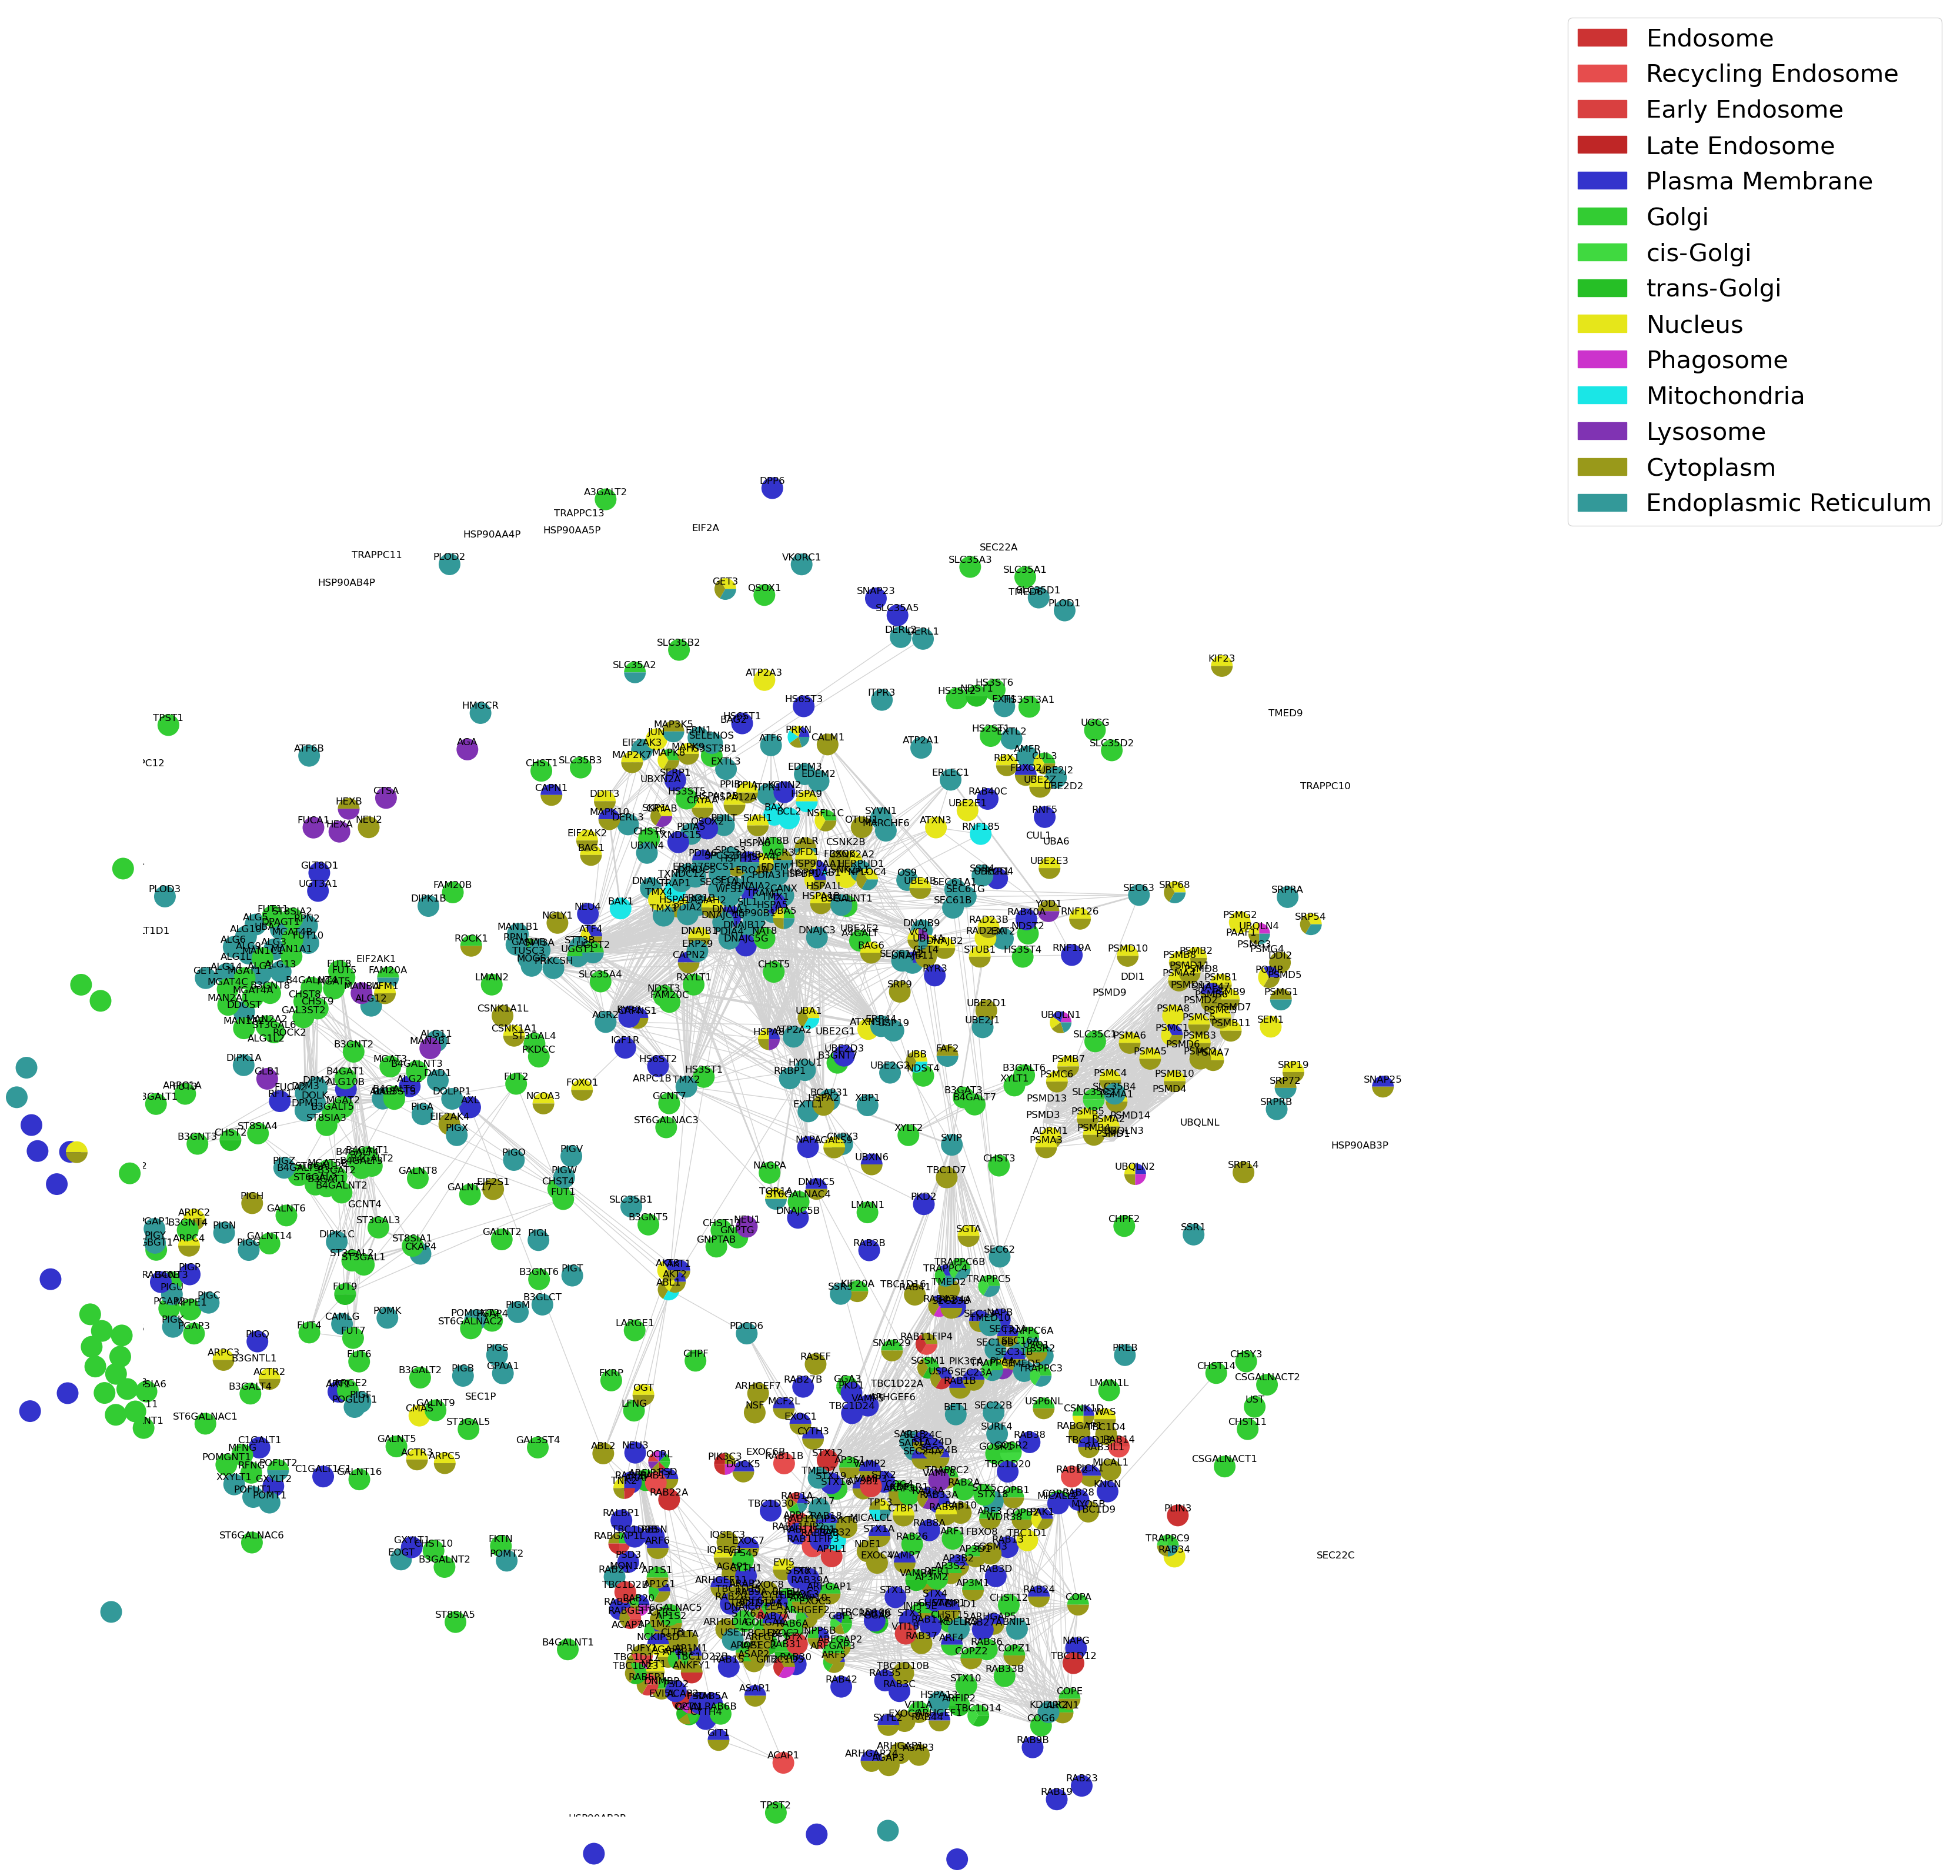

In [53]:
####--- Plot the genes grouped by processes and color coded by subcellular localization ---####

# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Create the figure first
fig, ax = plt.subplots(figsize=(40, 40))

# Layout
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.5)

# Draw edges first
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges()])

# Draw nodes as pie charts (after edges)
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    colors = [localization_colors[loc] for loc in localizations]
    plt.pie([1]*len(localizations), colors=colors, radius=0.015, center=(x, y))  # Reduced radius to 0.01

# Draw labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12)

# Legend
legend_patches = [mpatches.Patch(color=color, label=localization) for localization, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 30})

plt.savefig('gene_network_subcellularloc.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.3 Add the complex information to the plot and color by the processes

In [ ]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 100

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    
    # Check for shared complex
    shared_complex = gene_dict[gene1]['complex'] == gene_dict[gene2]['complex'] and gene_dict[gene1]['complex'] != 'Not part of any complex'
    if shared_complex:
        edge_weight = COMPLEX_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
    elif shared_processes > 0:
        edge_weight = shared_processes * PROCESS_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
        
# Color code node according to the System they belong to
base_alpha = 0.5 # Set base transparency level
node_colors = [adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), 1.0) if gene_dict[node]['complex'] != 'Not part of any complex' else adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), base_alpha) for node in G.nodes]

# Adjust node sizes according to whether they are part of a complex
node_sizes = [300 if gene_dict[node]['complex'] != 'Not part of any complex' else 300 for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)   # Set fixed position for nodes

# Create dictionary to store each complex's nodes' positions
complex_positions = {}

for gene in G.nodes:
    complex_ = gene_dict[gene]['complex']
    
    # Check if the gene is part of any complex
    if complex_ == 'Not part of any complex':
        continue
    
    # If the complex field is a list, iterate over each complex
    if isinstance(complex_, list):
        for comp in complex_:
            if comp not in complex_positions:
                complex_positions[comp] = []
            complex_positions[comp].append(pos[gene])
    else:  # If the complex field is a string, add the gene to the corresponding complex
        if complex_ not in complex_positions:
            complex_positions[complex_] = []
        complex_positions[complex_].append(pos[gene])
        
# Now compute average position and max radius for each complex
complex_centers_radii = {}
for complex_, positions in complex_positions.items():
    avg_position = np.mean(positions, axis=0)
    max_radius = max(np.linalg.norm(np.array(position)-avg_position) for position in positions)
    complex_centers_radii[complex_] = (avg_position, max_radius)


# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])

# Draw the circles for the complexes
for complex_, (center, radius) in complex_centers_radii.items():
    circle = Circle(center, radius, fill=False, edgecolor='grey', lw=1)
    ax.add_patch(circle)
    label_y_position = center[1] - radius - 0.01
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.savefig('secrecon_network_complex.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.4 Add the complex information to the plot and color by the subcellular localization

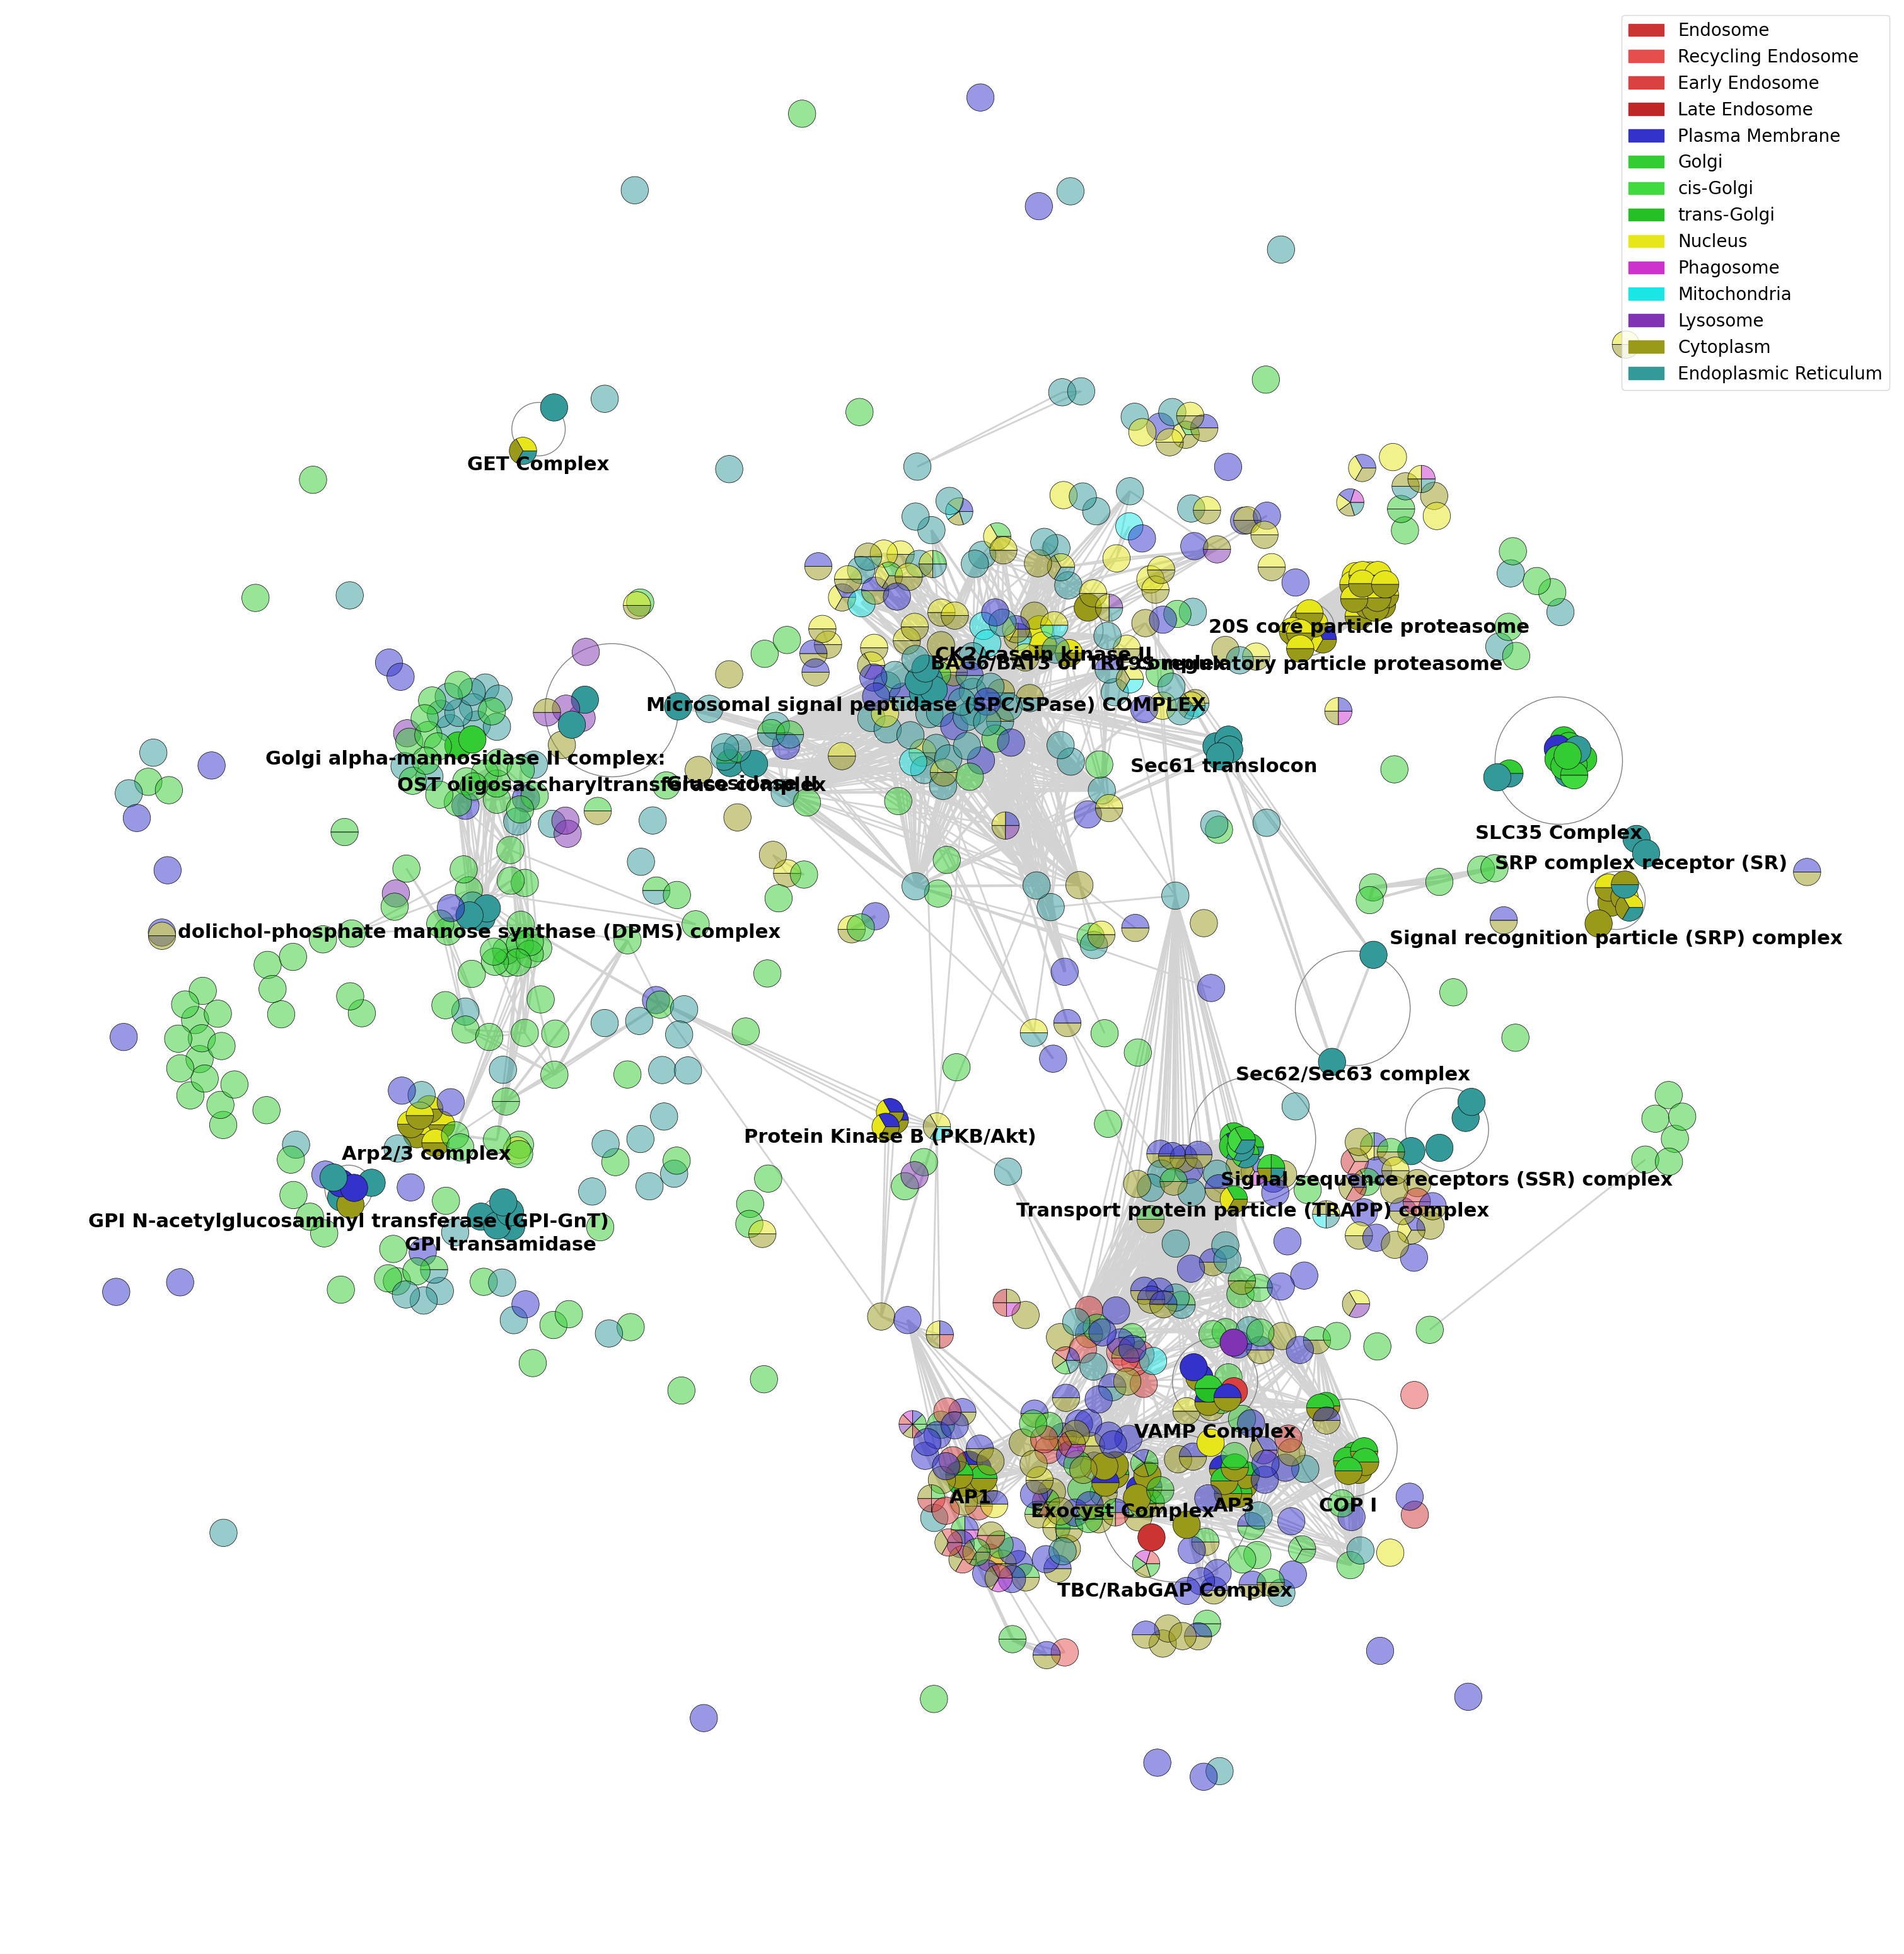

In [70]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 100

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    
    # Check for shared complex
    shared_complex = gene_dict[gene1]['complex'] == gene_dict[gene2]['complex'] and gene_dict[gene1]['complex'] != 'Not part of any complex'
    if shared_complex:
        edge_weight = COMPLEX_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
    elif shared_processes > 0:
        edge_weight = shared_processes * PROCESS_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
        
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Draw the graph layout
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])

# Draw the circles for the complexes
for complex_, (center, radius) in complex_centers_radii.items():
    circle = Circle(center, radius, fill=False, edgecolor='grey', lw=1)
    ax.add_patch(circle)
    label_y_position = center[1] - radius - 0.01
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')

def adjust_alpha(color, alpha):
    return (color[0], color[1], color[2], alpha)

# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Check if the node is part of any complex
    is_in_complex = gene_dict[node]['complex'] != 'Not part of any complex'
    
    # Set alpha value based on whether the node is in a complex
    alpha_value = 1.0 if is_in_complex else 0.5
    
    # Adjust the alpha value of each color
    colors = [adjust_alpha(localization_colors[loc], alpha_value) for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    ax.pie([1]*len(localizations), colors=colors, radius=0.015, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 20}, loc='upper right', bbox_to_anchor=(1, 1))

plt.savefig('gene_network_with_pie_charts.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 100

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    
    # Check for shared complex
    shared_complex = gene_dict[gene1]['complex'] == gene_dict[gene2]['complex'] and gene_dict[gene1]['complex'] != 'Not part of any complex'
    if shared_complex:
        edge_weight = COMPLEX_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
    elif shared_processes > 0:
        edge_weight = shared_processes * PROCESS_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
        
# Color code node according to the System they belong to
base_alpha = 0.5 # Set base transparency level
node_colors = [adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), 1.0) if gene_dict[node]['complex'] != 'Not part of any complex' else adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), base_alpha) for node in G.nodes]

# Adjust node sizes according to whether they are part of a complex
node_sizes = [300 if gene_dict[node]['complex'] != 'Not part of any complex' else 300 for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)   # Set fixed position for nodes

# Create dictionary to store each complex's nodes' positions
complex_positions = {}

for gene in G.nodes:
    complex_ = gene_dict[gene]['complex']
    
    # Check if the gene is part of any complex
    if complex_ == 'Not part of any complex':
        continue
    
    # If the complex field is a list, iterate over each complex
    if isinstance(complex_, list):
        for comp in complex_:
            if comp not in complex_positions:
                complex_positions[comp] = []
            complex_positions[comp].append(pos[gene])
    else:  # If the complex field is a string, add the gene to the corresponding complex
        if complex_ not in complex_positions:
            complex_positions[complex_] = []
        complex_positions[complex_].append(pos[gene])
        
# Now compute average position and convex hull for each complex
complex_centers_hulls = {}
complex_centers_radii = {}
for complex_, positions in complex_positions.items():
    if len(positions) > 2:  # Only compute convex hulls for complexes with more than 2 nodes
        hull = ConvexHull(positions)
        complex_centers_hulls[complex_] = hull
    else: #for those complexes that has 2 genes calculate the avg position to draw a circle
        avg_position = np.mean(positions, axis=0)
        max_radius = max(np.linalg.norm(np.array(position)-avg_position) for position in positions)
        complex_centers_radii[complex_] = (avg_position, max_radius)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])

# Draw the convex hulls for the complexes
for complex_, hull in complex_centers_hulls.items():
    # Draw the hull
    for simplex in hull.simplices:
        ax.plot(np.array(hull.points)[simplex, 0], np.array(hull.points)[simplex, 1], 'k-')
    # Draw the label
    center = np.mean(hull.points, axis=0)
    label_y_position = center[1] - 0.02
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')
    
# Draw the circles for the complexes
for complex_, (center, radius) in complex_centers_radii.items():
    circle = Circle(center, radius, fill=False, edgecolor='black', lw=1)
    ax.add_patch(circle)
    label_y_position = center[1] - radius - 0.01
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')

    
# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.savefig('secrecon_network_complex_2.png', dpi=300, bbox_inches='tight')
plt.show()